<a href="https://colab.research.google.com/github/hyein0623/hanghae-plus-AI/blob/main/Chapter1_1_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 예측 모델에 Deep learning techniques 적용하기




*   Dataset 및 activation 함수 변경
*   CIRAR10의 shap 확인
*   SGD와 Adam 성능 확인
*   Leaky ReLU와 sigmoid 성능 비교  
*   Dropout을 적용한 이후의 Generalization error 확인



#CIFAR10 데이터란 ?

32X32X3의 해상도로 사물 데이터를 모아놓은 데이터 세트이다.
CIFAR-10 데이터 세트는 비행기, 자동차, 새, 고양이 등 총 10개의 클래스로 구성된다.
학습데이터는 50,000개고 테스트 데이터는 10,000개이다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import SGD
from torch.optim import Adam

In [2]:
CIFAR_BATCH_SIZE = 256
NUM_EPOCHS=50
LEARNING_RATE=0.001

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

# 사용가능한 device  함수 정의


In [3]:
def get_device() -> torch.device:
    """
    cuda, cpu 순으로 사용 가능을 체크해서 반환
    :return: 사용 가능한 pytorch device
    """

    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# CIFAR-10 데이터 준비

In [4]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12932395.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## 테스트 데이터 만들기

In [5]:
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified



이 때, 우리는 PyTorch model을 사용할 것이기 때문에
CIFAR-10 데이터를  모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

# 예시 출력하기

50000
torch.Size([3, 32, 32]) 6


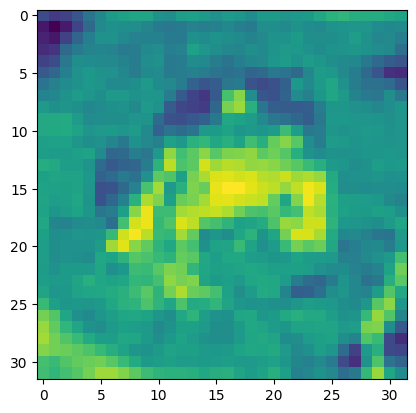

In [6]:

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0])

In [7]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=CIFAR_BATCH_SIZE,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = CIFAR_BATCH_SIZE,
    shuffle = False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


# CIFAR10 데이터 분류 모델 정의

In [9]:
class ClassificationModel(nn.Module):
  def __init__(self, num_channels, image_width, image_height, num_output_class):
    super(ClassificationModel, self).__init__()

    hidden_dim = 4096

    input_dim = num_channels * image_width * image_height

    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, hidden_dim)
    self.layer4 = nn.Linear(hidden_dim, num_output_class)

    #self.act = nn.ReLU()
    #nn.LeakyReLU로 변경
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))
    x = self.layer4(x)

    return x


In [10]:
device = get_device()
device

device(type='cuda')

In [11]:
model_for_sgd = ClassificationModel(3,32,32,10).to(device)
model_for_sgd

ClassificationModel(
  (layer1): Linear(in_features=3072, out_features=4096, bias=True)
  (layer2): Linear(in_features=4096, out_features=4096, bias=True)
  (layer3): Linear(in_features=4096, out_features=4096, bias=True)
  (layer4): Linear(in_features=4096, out_features=10, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)

In [12]:
model_for_adam  = ClassificationModel(3,32,32,10).to(device)
model_for_adam

ClassificationModel(
  (layer1): Linear(in_features=3072, out_features=4096, bias=True)
  (layer2): Linear(in_features=4096, out_features=4096, bias=True)
  (layer3): Linear(in_features=4096, out_features=4096, bias=True)
  (layer4): Linear(in_features=4096, out_features=10, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)

# Optimizer SGD 와  Adam 정의

In [13]:
sgd_optimizer = SGD(model_for_sgd.parameters(), lr=LEARNING_RATE)
sgd_optimizer

# loss function 생성
#criterion = torch.nn.CrossEntropyLoss()

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [14]:


adam_optimizer = Adam(model_for_adam.parameters(), lr=LEARNING_RATE)
adam_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [15]:
criterion = nn.CrossEntropyLoss()

# 정확도 평가 함수

In [16]:
def accuracy(device: torch.device, model, dataloader) -> float:
  cnt = 0
  acc = 0

  model.eval()
  with torch.no_grad():
    for data in dataloader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.size(0)
    acc += (labels == preds).sum().item()
  model.train()
  return acc / cnt

## 모델 학습

In [17]:
accuracies = np.zeros((2,2, NUM_EPOCHS))

optimizer 가 sdg 일때 학습

In [18]:

for epoch in range(NUM_EPOCHS):
  for data in trainloader:
    sgd_optimizer.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model_for_sgd(inputs)
    loss =criterion(preds, labels)
    loss.backward()
    sgd_optimizer.step()

  accuracies[0][0][epoch] = accuracy(device, model_for_sgd, trainloader)
  accuracies[0][1][epoch] = accuracy(device, model_for_sgd, testloader)


  print(f"Epoch {epoch:3d} | Train_accuracy: {accuracies[0][0][epoch]:.5f} | Test_accuracy: {accuracies[0][1][epoch]:.5f}")



Epoch   0 | Train_accuracy: 0.16250 | Test_accuracy: 0.12500
Epoch   1 | Train_accuracy: 0.11250 | Test_accuracy: 0.12500
Epoch   2 | Train_accuracy: 0.12500 | Test_accuracy: 0.12500
Epoch   3 | Train_accuracy: 0.17500 | Test_accuracy: 0.12500
Epoch   4 | Train_accuracy: 0.20000 | Test_accuracy: 0.18750
Epoch   5 | Train_accuracy: 0.08750 | Test_accuracy: 0.18750
Epoch   6 | Train_accuracy: 0.12500 | Test_accuracy: 0.12500
Epoch   7 | Train_accuracy: 0.16250 | Test_accuracy: 0.06250
Epoch   8 | Train_accuracy: 0.23750 | Test_accuracy: 0.06250
Epoch   9 | Train_accuracy: 0.17500 | Test_accuracy: 0.12500
Epoch  10 | Train_accuracy: 0.13750 | Test_accuracy: 0.12500
Epoch  11 | Train_accuracy: 0.20000 | Test_accuracy: 0.12500
Epoch  12 | Train_accuracy: 0.17500 | Test_accuracy: 0.12500
Epoch  13 | Train_accuracy: 0.15000 | Test_accuracy: 0.12500
Epoch  14 | Train_accuracy: 0.18750 | Test_accuracy: 0.18750
Epoch  15 | Train_accuracy: 0.22500 | Test_accuracy: 0.18750
Epoch  16 | Train_accura

# optimizer 가 Adam 일때 학습

In [19]:

for epoch in range(NUM_EPOCHS):
  for data in trainloader:
    adam_optimizer.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model_for_adam(inputs)
    loss =criterion(preds, labels)
    loss.backward()
    adam_optimizer.step()

  accuracies[1][0][epoch] = accuracy(device, model_for_adam, trainloader)
  accuracies[1][1][epoch] = accuracy(device, model_for_adam, testloader)


  print(f"Epoch {epoch:3d} | Train_accuracy: {accuracies[1][0][epoch]:.5f} | Test_accuracy: {accuracies[1][1][epoch]:.5f}")



Epoch   0 | Train_accuracy: 0.25000 | Test_accuracy: 0.18750
Epoch   1 | Train_accuracy: 0.26250 | Test_accuracy: 0.37500
Epoch   2 | Train_accuracy: 0.37500 | Test_accuracy: 0.31250
Epoch   3 | Train_accuracy: 0.46250 | Test_accuracy: 0.25000
Epoch   4 | Train_accuracy: 0.38750 | Test_accuracy: 0.31250
Epoch   5 | Train_accuracy: 0.42500 | Test_accuracy: 0.31250
Epoch   6 | Train_accuracy: 0.33750 | Test_accuracy: 0.31250
Epoch   7 | Train_accuracy: 0.43750 | Test_accuracy: 0.31250
Epoch   8 | Train_accuracy: 0.45000 | Test_accuracy: 0.25000
Epoch   9 | Train_accuracy: 0.55000 | Test_accuracy: 0.37500
Epoch  10 | Train_accuracy: 0.51250 | Test_accuracy: 0.50000
Epoch  11 | Train_accuracy: 0.48750 | Test_accuracy: 0.12500
Epoch  12 | Train_accuracy: 0.43750 | Test_accuracy: 0.37500
Epoch  13 | Train_accuracy: 0.60000 | Test_accuracy: 0.43750
Epoch  14 | Train_accuracy: 0.53750 | Test_accuracy: 0.43750
Epoch  15 | Train_accuracy: 0.57500 | Test_accuracy: 0.50000
Epoch  16 | Train_accura

# Accuracy 그래프

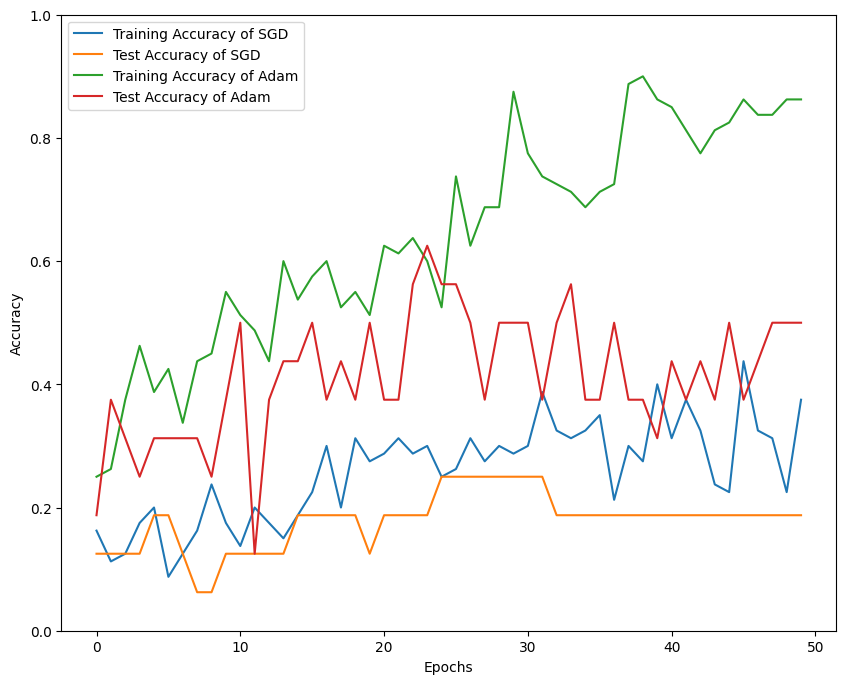

In [20]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(NUM_EPOCHS)
plt.plot(x_axis, accuracies[0][0], label="Training Accuracy of SGD")
plt.plot(x_axis, accuracies[0][1], label="Test Accuracy of SGD")
plt.plot(x_axis, accuracies[1][0], label="Training Accuracy of Adam")
plt.plot(x_axis, accuracies[1][1], label="Test Accuracy of Adam")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

# Sigmoid 를 활성 함수로 적용한 분류 모델

In [23]:
class ClassificationModel2(nn.Module):
  def __init__(self, num_channels, image_width, image_height, num_output_class):
    super(ClassificationModel2, self).__init__()

    hidden_dim = 4096

    input_dim = num_channels * image_width * image_height

    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, hidden_dim)
    self.layer4 = nn.Linear(hidden_dim, num_output_class)

    #self.act = nn.ReLU()
    #nn.LeakyReLU로 변경
    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))
    x = self.layer4(x)

    return x

# 학습

In [24]:
sigmoid_model = ClassificationModel2(3,32,32,10).to(device)
sigmoid_model_optimizer = Adam(sigmoid_model.parameters(), lr=LEARNING_RATE)

sigmoid_accuracies = np.zeros((2, NUM_EPOCHS))

for epoch in range(NUM_EPOCHS):
  for data in trainloader:
    sigmoid_model_optimizer.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = sigmoid_model(inputs)
    loss =criterion(preds, labels)
    loss.backward()
    sigmoid_model_optimizer.step()

  sigmoid_accuracies[0][epoch] = accuracy(device, sigmoid_model, trainloader)
  sigmoid_accuracies[1][epoch] = accuracy(device, sigmoid_model, testloader)


  print(f"Epoch {epoch:3d} | Train_accuracy: {sigmoid_accuracies[0][epoch]:.5f} | Test_accuracy: {sigmoid_accuracies[1][epoch]:.5f}")



Epoch   0 | Train_accuracy: 0.17500 | Test_accuracy: 0.31250
Epoch   1 | Train_accuracy: 0.10000 | Test_accuracy: 0.06250
Epoch   2 | Train_accuracy: 0.18750 | Test_accuracy: 0.06250
Epoch   3 | Train_accuracy: 0.15000 | Test_accuracy: 0.00000
Epoch   4 | Train_accuracy: 0.21250 | Test_accuracy: 0.06250
Epoch   5 | Train_accuracy: 0.26250 | Test_accuracy: 0.12500
Epoch   6 | Train_accuracy: 0.23750 | Test_accuracy: 0.18750
Epoch   7 | Train_accuracy: 0.25000 | Test_accuracy: 0.37500
Epoch   8 | Train_accuracy: 0.32500 | Test_accuracy: 0.25000
Epoch   9 | Train_accuracy: 0.40000 | Test_accuracy: 0.37500
Epoch  10 | Train_accuracy: 0.32500 | Test_accuracy: 0.37500
Epoch  11 | Train_accuracy: 0.45000 | Test_accuracy: 0.37500
Epoch  12 | Train_accuracy: 0.42500 | Test_accuracy: 0.25000
Epoch  13 | Train_accuracy: 0.42500 | Test_accuracy: 0.25000
Epoch  14 | Train_accuracy: 0.42500 | Test_accuracy: 0.37500
Epoch  15 | Train_accuracy: 0.42500 | Test_accuracy: 0.50000
Epoch  16 | Train_accura

# LeakyReLu 와 Sigmoid 활성 함수 별 분류 모델 정확도

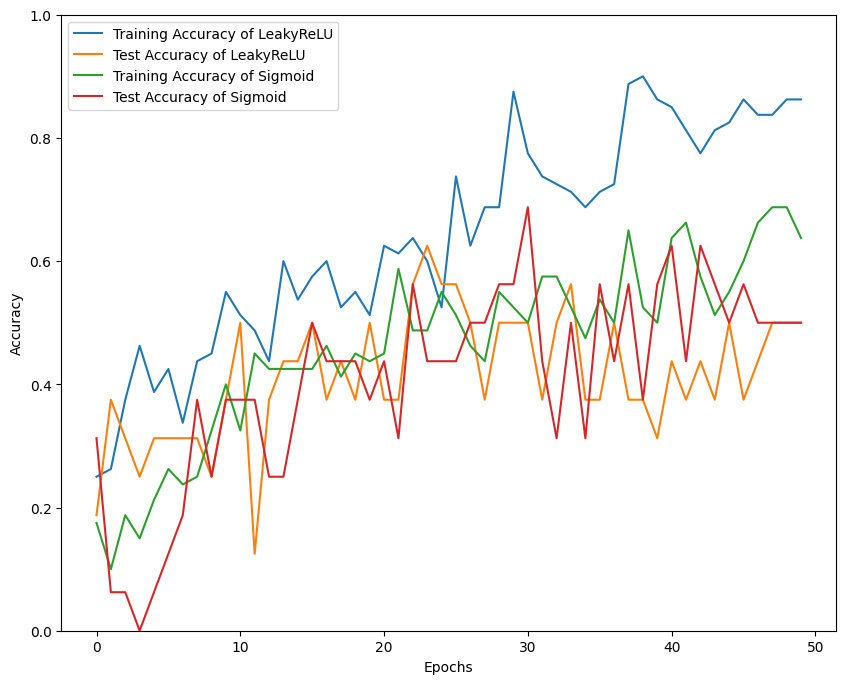

In [25]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(NUM_EPOCHS)
plt.plot(x_axis, accuracies[1][0], label="Training Accuracy of LeakyReLU")
plt.plot(x_axis, accuracies[1][1], label="Test Accuracy of LeakyReLU")
plt.plot(x_axis, sigmoid_accuracies[0], label="Training Accuracy of Sigmoid")
plt.plot(x_axis, sigmoid_accuracies[1], label="Test Accuracy of Sigmoid")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()

# Drop out 을 적용한 분류 모델

In [26]:
class ClassificationModel3(nn.Module):
  def __init__(self, num_channels, image_width, image_height, num_output_class):
    super(ClassificationModel3, self).__init__()

    hidden_dim = 4096

    input_dim = num_channels * image_width * image_height

    self.layer1 = nn.Linear(input_dim, hidden_dim)
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, hidden_dim)
    self.layer4 = nn.Linear(hidden_dim, num_output_class)

    #self.act = nn.ReLU()
    #nn.LeakyReLU로 변경

    self.dropout = nn.Dropout(p=0.1)
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.dropout(self.layer1(x)))
    x = self.act(self.dropout(self.layer2(x)))
    x = self.act(self.dropout(self.layer3(x)))
    x = self.layer4(x)

    return x

학습

In [27]:
dropout_model = ClassificationModel3(3,32,32,10).to(device)
dropout_model_optimizer = Adam(dropout_model.parameters(), lr=LEARNING_RATE)

dropout_accuracies = np.zeros((2, NUM_EPOCHS))

for epoch in range(NUM_EPOCHS):
  for data in trainloader:
    dropout_model_optimizer.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = dropout_model(inputs)
    loss =criterion(preds, labels)
    loss.backward()
    dropout_model_optimizer.step()

  dropout_accuracies[0][epoch] = accuracy(device, dropout_model, trainloader)
  dropout_accuracies[1][epoch] = accuracy(device, dropout_model, testloader)


  print(f"Epoch {epoch:3d} | Train_accuracy: {dropout_accuracies[0][epoch]:.5f} | Test_accuracy: {dropout_accuracies[1][epoch]:.5f}")


Epoch   0 | Train_accuracy: 0.32500 | Test_accuracy: 0.12500
Epoch   1 | Train_accuracy: 0.31250 | Test_accuracy: 0.37500
Epoch   2 | Train_accuracy: 0.32500 | Test_accuracy: 0.25000
Epoch   3 | Train_accuracy: 0.43750 | Test_accuracy: 0.31250
Epoch   4 | Train_accuracy: 0.48750 | Test_accuracy: 0.37500
Epoch   5 | Train_accuracy: 0.51250 | Test_accuracy: 0.31250
Epoch   6 | Train_accuracy: 0.35000 | Test_accuracy: 0.43750
Epoch   7 | Train_accuracy: 0.50000 | Test_accuracy: 0.31250
Epoch   8 | Train_accuracy: 0.45000 | Test_accuracy: 0.37500
Epoch   9 | Train_accuracy: 0.50000 | Test_accuracy: 0.37500
Epoch  10 | Train_accuracy: 0.45000 | Test_accuracy: 0.31250
Epoch  11 | Train_accuracy: 0.55000 | Test_accuracy: 0.37500
Epoch  12 | Train_accuracy: 0.50000 | Test_accuracy: 0.37500
Epoch  13 | Train_accuracy: 0.56250 | Test_accuracy: 0.37500
Epoch  14 | Train_accuracy: 0.56250 | Test_accuracy: 0.56250
Epoch  15 | Train_accuracy: 0.56250 | Test_accuracy: 0.50000
Epoch  16 | Train_accura

# Drop out 적용 유무 분류 정확도 그래프

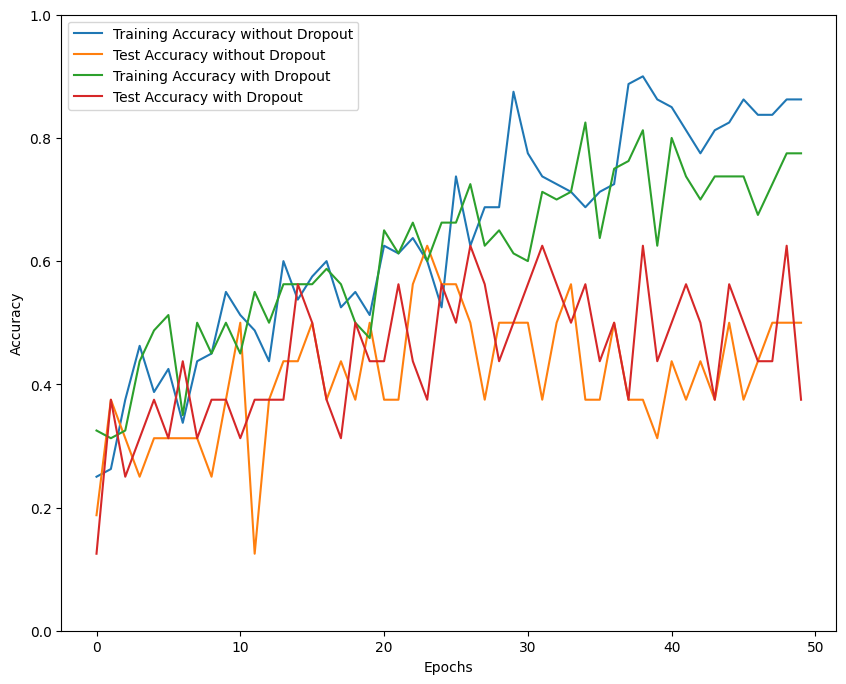

In [28]:
plt.figure(figsize=(10, 8))

x_axis = np.arange(NUM_EPOCHS)
plt.plot(x_axis, accuracies[1][0], label="Training Accuracy without Dropout")
plt.plot(x_axis, accuracies[1][1], label="Test Accuracy without Dropout")
plt.plot(x_axis, dropout_accuracies[0], label="Training Accuracy with Dropout")
plt.plot(x_axis, dropout_accuracies[1], label="Test Accuracy with Dropout")

plt.legend()

plt.ylim([0, 1])
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

plt.show()